In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

## Creation of the matrix (just load, last line)

In [2]:
orders = pd.read_csv('data/orders.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')

In [ ]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')

In [ ]:
#orders_small = orders[["order_id","user_id"]].sort_values(by='order_id')#.head(105629)
history_small = history.head(5000000)

In [ ]:
consumptions = pd.merge(history_small, orders, on="order_id")[['user_id','product_id']]

In [ ]:
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
consumptions_with_details.head()

In [ ]:
max_user_id = max(consumptions_with_details["user_id"])
print('The greatest user id is '+str(max_user_id)+".")

In [ ]:
# We split the dataframe into 2 smaller ones, because the kernel crashes at the next step if we keep the big one
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

In [ ]:
max_aisle_id = max(consumptions_with_details.aisle_id)
print("The greatest aisle id is "+str(max_aisle_id)+".")

In [ ]:
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_1.head()

In [ ]:
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1

def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

In [ ]:
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

In [ ]:
# Load the user matrix
f=open("user_matrix","rb")
user_matrix = pickle.load(f)
f.close()

In [3]:
user_matrix = pd.read_pickle('matrix.p') #Load directly the matrix
user_matrix = user_matrix[1:] #first row is empty

## Determine the optimal k

In [ ]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(user_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss,marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow method : the optimal number is k=3

Verification with silhouette methode :

In [ ]:
#NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s1 = silhouette_score(user_matrix, labels)
#s1

In [ ]:
# NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s2 = silhouette_score(user_matrix, labels)
#s2

Silhouette method actually gives 2

## Cluster sizes

In [3]:
def get_cluster_size(clustering, nb_clusters,matrix=user_matrix) :
    for k in range(nb_clusters):
        number_users_in_cluster = 0.
        for user_index in range(1,len(matrix)) :
            if kmeans.labels_[user_index]==k :
                number_users_in_cluster+=1
        print(number_users_in_cluster)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 2)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 3)

Clusters are very inequal, this clustering is not relevant.

## Clustering avec contrainte sur clusters size

In [ ]:
import constrained_kmeans as cons

In [ ]:
#ne pas run : tres tres long
(C,M,f) = cons.constrained_kmeans(user_matrix, [92794,92794], maxiter=50)

Way too long to run (more than 6hours), never finished

## Dimensionnality reduction

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [4]:
user_matrix = np.array(user_matrix)

In [5]:
row_sums = user_matrix.sum(axis=1) #Normalize on the rows (rows_sum -> 1)
norm_matrix = user_matrix / row_sums[:, np.newaxis]
for (i, l) in enumerate(norm_matrix) :
    if str(l[0])=="nan":
        for k in range(0, len(norm_matrix[0])):
            norm_matrix[i][k]=0

In [6]:
pca = PCA(random_state=0) 
pca.fit(norm_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
reduc_matrix = pca.transform(norm_matrix)

Determine the right number of dimensions as a trade-off between number of dimensions and loss of variance.

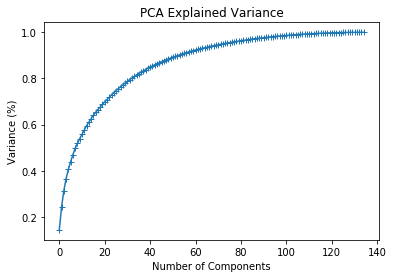

In [8]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='+')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.show()

dimension choosen at the elbow : dim=30

In [6]:
pca = PCA(n_components=30, random_state=0)
reduc_matrix = pca.fit_transform(norm_matrix)

In [10]:
reduc_matrix.shape

(206209, 30)

Understand the new dimension vectors by looking at the features impacting them the most

In [11]:
aisles = pd.read_csv('data/aisles.csv', sep=',')

In [7]:
aisle_list = list(aisles.aisle)
i=0
for d in pca.components_ :
    print("dimension" + str(i)+" ") 
    i+=1
    if abs(np.max(d))>=abs(np.min(d)):
        print(str(aisle_list[np.argmax(d)-1]) + " " + str(np.max(d)))
    else :
        print(str(aisle_list[np.argmin(d)-1])+" "+str(np.min(d)))

dimension0 
fresh vegetables 0.7076249915554522
dimension1 
fresh fruits 0.7533425977856487
dimension2 
water seltzer sparkling water 0.931221598490975
dimension3 
packaged produce 0.7982154539962941
dimension4 
yogurt 0.7631546502389212
dimension5 
packaged vegetables fruits 0.7993179622678135
dimension6 
milk 0.7211703755630717
dimension7 
milk 0.5998370338124163
dimension8 
ice cream ice 0.8680504046854851
dimension9 
refrigerated 0.7799553135607814
dimension10 
chips pretzels 0.7043137176031647
dimension11 
soy lactosefree 0.61176972053749
dimension12 
frozen meals 0.767203591396996
dimension13 
soy lactosefree 0.62058470813182
dimension14 
energy granola bars 0.8148584261837684
dimension15 
baby food formula 0.864075888099556
dimension16 
frozen produce 0.8553487130401553
dimension17 
candy chocolate 0.7314468710107994
dimension18 
cereal 0.513188786786723
dimension19 
bread 0.5442520764951067
dimension20 
juice nectars 0.8595065968041726
dimension21 
cream 0.524202994524218
dimen

We can see that the aisles determining the first independant dimensions (fresh vegetables, fresh fruits, water, packaged produces) may be related to healthiness. 

Determine the right number of clusters (k)

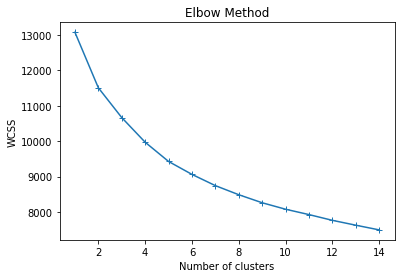

In [14]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduc_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss, marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal k is 5 with this method

In [7]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(reduc_matrix)

In [16]:
get_cluster_size(kmeans, 5, reduc_matrix)

38233.0
55661.0
7932.0
5366.0
99016.0


Instacart users can be split in 5 groups : 3 mains groups, and two very small.

## Analyse the clusters

**Look at centroids distance**

In [17]:
kmeans.cluster_centers_

array([[ 6.71504001e-02,  1.05080601e-01, -1.21770598e-03,
        -3.08570484e-02, -1.05411714e-02,  7.26897553e-03,
        -5.20583165e-04,  4.47131860e-03, -7.54747073e-04,
        -1.45952241e-04, -7.32296138e-04,  3.40642579e-05,
        -1.45034863e-03,  6.79077115e-04, -2.62330407e-04,
        -1.59982211e-04,  4.51228080e-04,  2.63687806e-04,
         3.61374268e-04,  5.99210042e-04,  3.12089635e-04,
        -4.04786463e-04,  1.98799717e-04,  2.55235581e-04,
         6.02676207e-04, -1.01206450e-04, -8.59671313e-05,
         3.43152540e-04, -2.10098292e-04,  9.35083882e-05],
       [ 1.05715927e-01, -7.33360176e-02,  1.73096174e-02,
         3.73793823e-03,  1.77693524e-03, -4.46848732e-03,
        -9.59793352e-04,  1.29292810e-03, -1.57508943e-04,
         7.91431212e-04,  1.29861761e-03,  1.10564280e-03,
         7.50951522e-04,  3.78520709e-04,  9.53589195e-04,
        -4.51014531e-04, -1.03737808e-04,  8.98614464e-04,
        -3.38762381e-04, -4.17722850e-04,  6.53295486e-

In [18]:
def dist_centroids(clustering):
    k=len(clustering.cluster_centers_)
    distances = np.zeros((k,k))
    for x in range(k):
        for y in range(x):
            dist = np.linalg.norm(clustering.cluster_centers_[x]-clustering.cluster_centers_[y]) #calculate euclidian distance
            distances[x,y]=dist
    return distances

In [19]:
dist_centroids(kmeans)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.18755526, 0.        , 0.        , 0.        , 0.        ],
       [0.30017687, 0.34356591, 0.        , 0.        , 0.        ],
       [0.42653041, 0.43958819, 0.4761357 , 0.        , 0.        ],
       [0.18624965, 0.19612675, 0.3105995 , 0.3704018 , 0.        ]])

clusters 2 and 3 can be said 'basic' : they look to all others, and are alike. Note that there are also the two small clusters. These users are very close to the others, it was probably just to difficult to differentiate them clearly.

**prepare df**

In [12]:
#convert the matrix into df
matrix_df = pd.DataFrame(user_matrix, index = range(len(user_matrix)), columns = ['Null']+list(aisles.aisle) )
matrix_df = matrix_df.drop('Null', axis=1) #drop first useless column
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Add a column 'cluster'
matrix_df['cluster']=kmeans.labels_
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
#Convert Normalized matrix into a df
norm_matrix_df = pd.DataFrame(norm_matrix, index = range(len(norm_matrix)), columns = ['Null']+list(aisles.aisle) )
norm_matrix_df = norm_matrix_df.drop('Null', axis=1) #drop first useless column
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.005128,0.0,0.030769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.055556
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [15]:
#Add column 'cluster'
norm_matrix_df['cluster']=kmeans.labels_
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4
1,0.005128,0.0,0.030769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0
2,0.000000,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.055556,4
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1


**Study the mean distribution of products per ailse in each clusters**

In [24]:
mean_clusters = norm_matrix_df.groupby(['cluster']).mean()
mean_clusters

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.002626,0.002323,0.012865,0.004271,0.001138,0.000945,0.000785,0.001214,0.005298,0.000193,...,0.001251,0.000337,0.000553,0.004380,0.004436,0.004763,0.005874,0.000113,0.000482,0.000170
1,0.001635,0.002933,0.007811,0.004021,0.002122,0.000928,0.001297,0.000688,0.007335,0.000297,...,0.000328,0.000349,0.000450,0.005712,0.003614,0.004043,0.009116,0.000135,0.000310,0.000166
2,0.002437,0.001125,0.003834,0.001141,0.000431,0.000429,0.002486,0.002222,0.001826,0.000707,...,0.003229,0.000000,0.000814,0.001196,0.001192,0.001685,0.000763,0.000046,0.001504,0.000707
3,0.001277,0.001079,0.013829,0.001724,0.000486,0.001228,0.000675,0.001318,0.001338,0.000554,...,0.003322,0.000693,0.002538,0.001111,0.001352,0.002477,0.001707,0.000148,0.001797,0.000689
4,0.002743,0.002495,0.015161,0.008394,0.002436,0.001847,0.001093,0.001825,0.007002,0.000531,...,0.001983,0.001353,0.003069,0.006158,0.007776,0.005129,0.007976,0.000356,0.001309,0.001227


**Evaluate the features discrimining the clusters**

In [25]:
matrix_df.corr()['cluster'].sort_values(ascending=True)

fresh fruits                 -0.311720
fresh vegetables             -0.277253
packaged vegetables fruits   -0.197503
fresh herbs                  -0.176744
poultry counter              -0.086046
                                ...   
cleaning products             0.125984
body lotions soap             0.136126
paper goods                   0.136513
soft drinks                   0.153559
cluster                       1.000000
Name: cluster, Length: 135, dtype: float64

The features influencing the most the cluster affiliation seem to be the 9 ones listed above 
_not convinced by the method_

In [26]:
array = norm_matrix_df.values
X = array[:,0:-1]
Y = array[:,-1]

In [27]:
scores = SelectKBest(chi2, k=20).fit(X, Y)

In [28]:
features = pd.DataFrame(index=norm_matrix_df.columns[:-1], data= scores.scores_, columns=["Score"]).sort_values("Score",ascending=False)
features.head(10)

,Score
packaged produce,36182.246946
water seltzer sparkling water,21547.167605
fresh vegetables,12607.893035
fresh fruits,8476.947723
soft drinks,1526.762953
fresh herbs,1209.352566
packaged vegetables fruits,1100.078211
frozen meals,644.995977
paper goods,561.429783
ice cream ice,522.070240


The aisles impacting the clustering are packaged produce, water, and then fresh vegetables and fruits, and soft drinks. Note that it is coherent with the features impacting the first dimensions. However, this is not exactly clustered on healthiness.

In [29]:
imp_features = features.head(10).index

In [30]:
mean_clusters[imp_features]

,packaged produce,water seltzer sparkling water,fresh vegetables,fresh fruits,soft drinks,fresh herbs,packaged vegetables fruits,frozen meals,paper goods,ice cream ice
cluster,,,,,,,,,,
0,0.011045,0.021670,0.075563,0.228131,0.006999,0.008120,0.070707,0.008015,0.004468,0.012104
1,0.003952,0.017446,0.218774,0.111934,0.004512,0.022809,0.066753,0.006371,0.004489,0.011409
2,0.292983,0.025529,0.043707,0.147302,0.013028,0.000290,0.060935,0.006034,0.002088,0.004134
3,0.015740,0.390199,0.014466,0.041773,0.053002,0.001618,0.018640,0.005504,0.017362,0.011205
4,0.005359,0.026973,0.041975,0.052864,0.024125,0.005401,0.036271,0.019585,0.014133,0.024045


0 : bcp de fresh fruits ; peu de soft drinks

1 : tres peu de packaged ; bcp de fresh vegetables  ; peu de soft drinks ; bcp herbs

2 : bcp de packaged ; peu d'herbs ; peu ice cream

3 :  bcp de sparkling water ; peu de fresh fruits ; peu de pack veg fruits ; bcp paper

4 : tres peu de packaged ; peu de fresh fruits ; peu de pack veg fruits ; bcp frozen meals ; bcp paper ; plus ice cream

classification healthiness : 1>0 (bons)  >  (mauvais) 3>2>4

## Vizualisation 

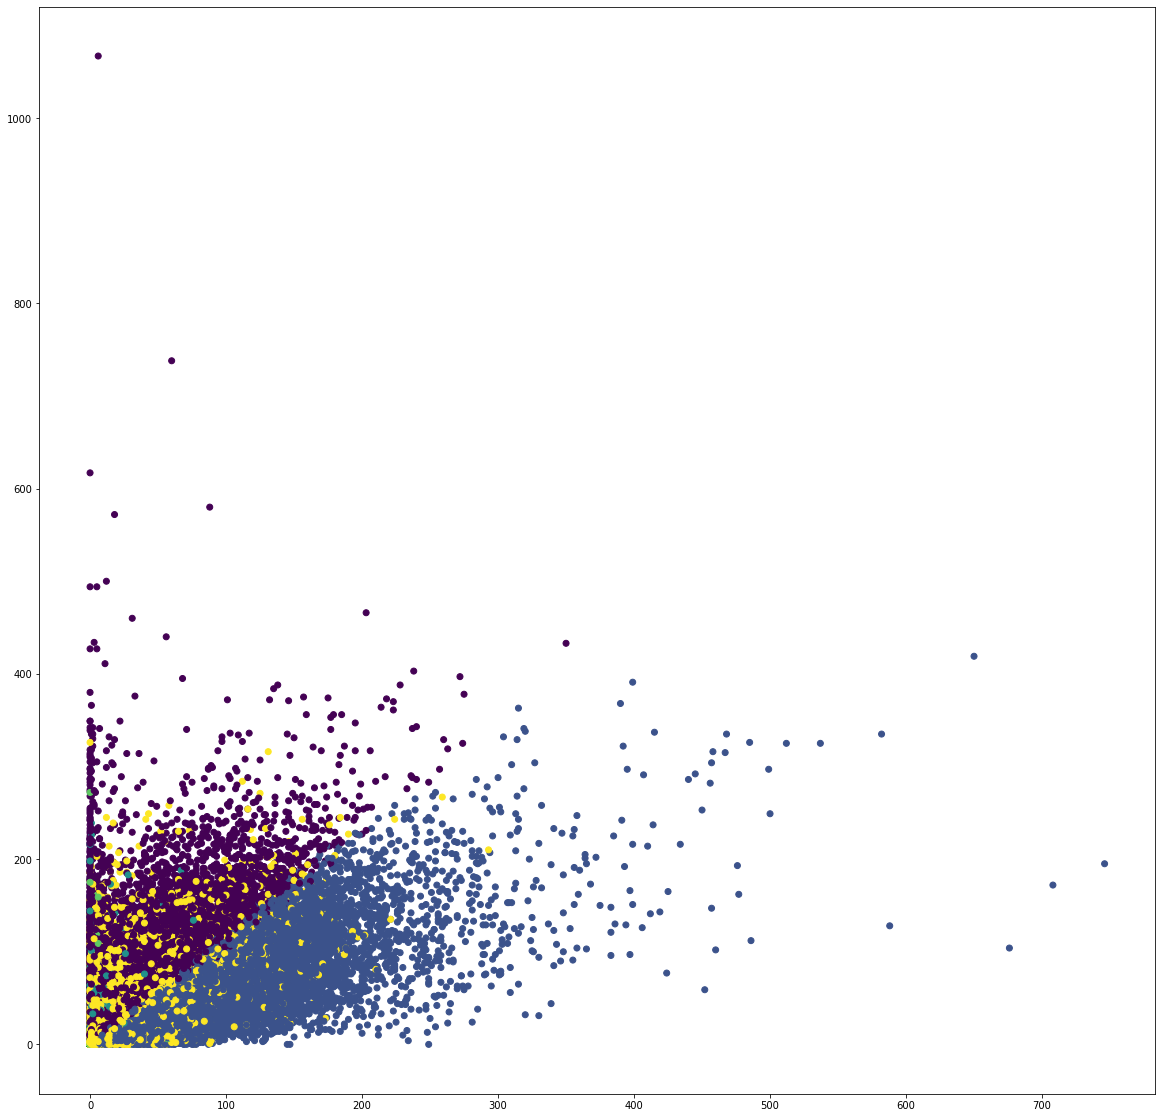

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(matrix_df['fresh vegetables'], matrix_df['fresh fruits'], c=matrix_df['cluster'], cmap='viridis')
#centers = kmeans.cluster_centers_
#plt.scatter(centers['fresh_vegetables'], centers['fresh_fruits'], c='black', alpha=0.5);

We can see that two of the clusters (0 ans 1) are well separated, but the two smalls and the 4th cluster are not separated in these dimensions. There is no clear separation between clusters, which is not really surprising, because habits are probably a continuum over users. Actually, the clear separation between clusters 0 and 1 is more surprising : it seems like an artificially imposed separation.

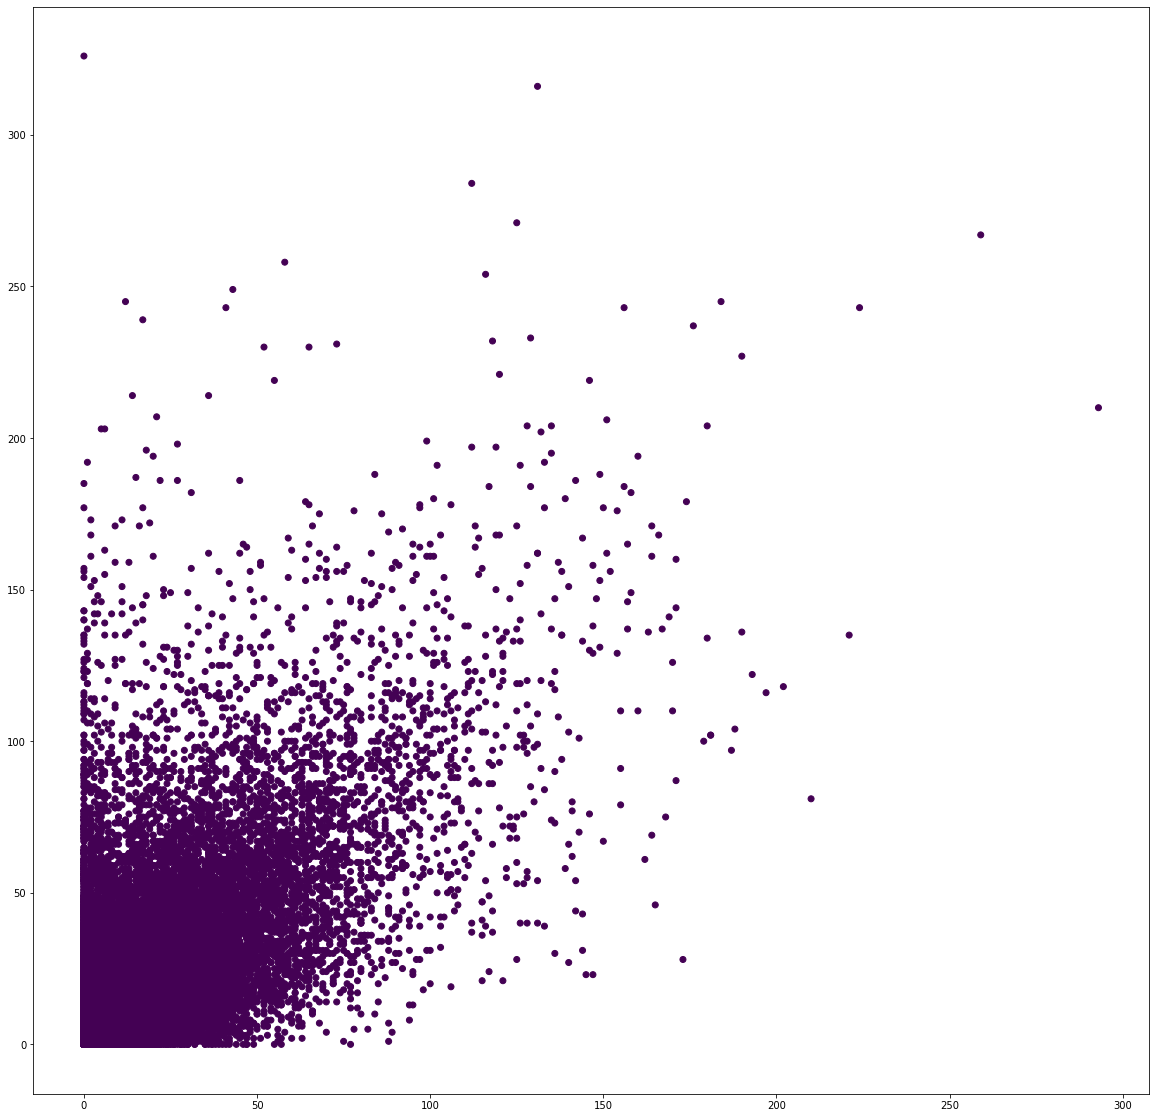

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
dessin = matrix_df[matrix_df.cluster ==4  ]
ax.scatter(dessin['fresh vegetables'], dessin['fresh fruits'], c=dessin['cluster'], cmap='viridis')

As we can see, the cluster 4 is not separated from the others at all 

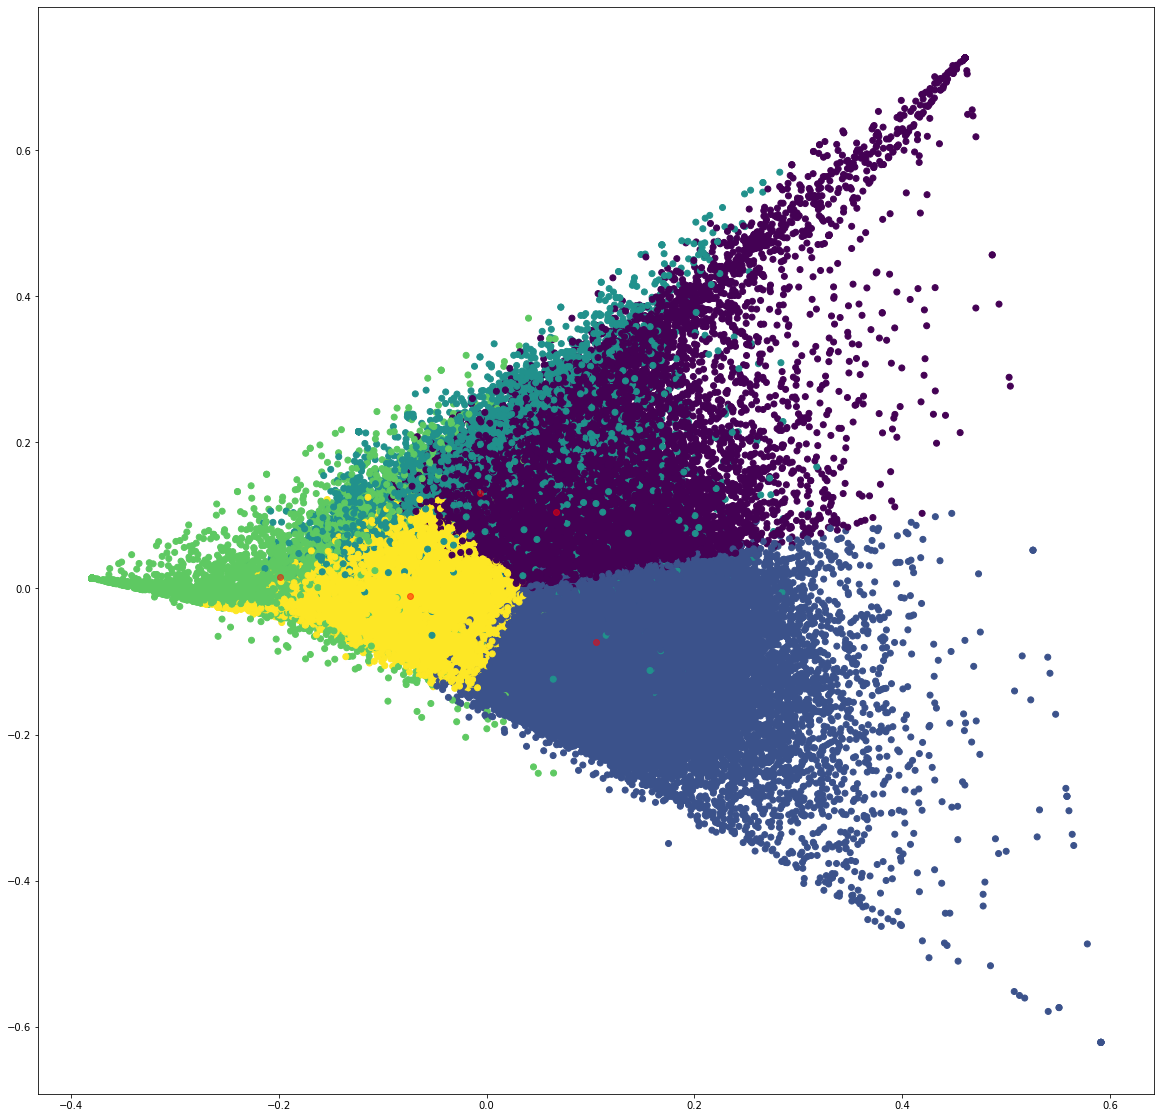

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(reduc_matrix[:,0], reduc_matrix[:,1], c=kmeans.labels_, cmap='viridis')
centers = kmeans.cluster_centers_
ax.scatter(centers[:,0], centers[:,1], c='red', alpha=0.5);

Representation in the first two dimensions of the PCA. We can see how the clusters were defined. As expected, the small clusters (1 and 2) are not well separated, close to all other centroids. The three other are much well defined, but like before, the separation seems artificially imposed. This is probably due to a difficulty to really differentiate the users, because of the continuum if their habits.

## Habits

In [9]:
def stats_cluster(nb_cluster):
    user = matrix_df.index[matrix_df.cluster==nb_cluster]

    # Timing of orders
    print (orders[orders.user_id.isin(user)].groupby('order_id').mean().describe())

In [16]:
stats_cluster(0)

             user_id   order_number      order_dow  order_hour_of_day  \
count  635446.000000  635446.000000  635446.000000      635446.000000   
mean   103200.993453      17.309128       2.780628          13.450134   
std     59238.774067      17.929014       2.047034           4.224018   
min         1.000000       1.000000       0.000000           0.000000   
25%     51657.000000       5.000000       1.000000          10.000000   
50%    103268.000000      11.000000       3.000000          13.000000   
75%    154334.000000      24.000000       5.000000          16.000000   
max    206201.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           597213.000000  
mean                11.051282  
std                  9.192371  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [17]:
stats_cluster(1)

             user_id   order_number      order_dow  order_hour_of_day  \
count  922246.000000  922246.000000  922246.000000      922246.000000   
mean   102575.428146      17.169224       2.777506          13.449460   
std     59515.351371      17.785143       2.047414           4.226912   
min         4.000000       1.000000       0.000000           0.000000   
25%     50792.000000       5.000000       1.000000          10.000000   
50%    102070.000000      11.000000       3.000000          13.000000   
75%    154080.000000      23.000000       5.000000          16.000000   
max    206202.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           866585.000000  
mean                11.124271  
std                  9.215804  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [18]:
stats_cluster(2)

             user_id   order_number      order_dow  order_hour_of_day  \
count  132012.000000  132012.000000  132012.000000      132012.000000   
mean   103931.318797      17.236789       2.773149          13.413750   
std     59734.206598      17.841536       2.044730           4.222624   
min        51.000000       1.000000       0.000000           0.000000   
25%     52683.000000       5.000000       1.000000          10.000000   
50%    103807.000000      11.000000       3.000000          13.000000   
75%    155402.000000      23.000000       5.000000          16.000000   
max    206141.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           124080.000000  
mean                11.147695  
std                  9.228813  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [19]:
stats_cluster(3)

             user_id  order_number     order_dow  order_hour_of_day  \
count   88126.000000  88126.000000  88126.000000       88126.000000   
mean   103535.934174     17.117922      2.792933          13.453249   
std     59786.692922     17.948948      2.048201           4.240662   
min        29.000000      1.000000      0.000000           0.000000   
25%     51701.000000      5.000000      1.000000          10.000000   
50%    103824.000000     11.000000      3.000000          13.000000   
75%    153856.000000     23.000000      5.000000          16.000000   
max    206170.000000    100.000000      6.000000          23.000000   

       days_since_prior_order  
count            82760.000000  
mean                11.106187  
std                  9.230581  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [20]:
stats_cluster(4)

            user_id  order_number     order_dow  order_hour_of_day  \
count  1.643239e+06  1.643239e+06  1.643239e+06       1.643239e+06   
mean   1.030108e+05  1.708262e+01  2.773140e+00       1.345718e+01   
std    5.962587e+04  1.760661e+01  2.046513e+00       4.225920e+00   
min    3.000000e+00  1.000000e+00  0.000000e+00       0.000000e+00   
25%    5.149300e+04  5.000000e+00  1.000000e+00       1.000000e+01   
50%    1.026360e+05  1.100000e+01  3.000000e+00       1.300000e+01   
75%    1.544460e+05  2.300000e+01  5.000000e+00       1.600000e+01   
max    2.062080e+05  1.000000e+02  6.000000e+00       2.300000e+01   

       days_since_prior_order  
count            1.544223e+06  
mean             1.113188e+01  
std              9.204006e+00  
min              0.000000e+00  
25%              4.000000e+00  
50%              7.000000e+00  
75%              1.500000e+01  
max              3.000000e+01  


There is no differences of users's habits between the clusters... (days and hour of orders, days after the last order, number of orders). This is disappointing, there is no advice to give to the less healthy group here.

In [21]:
def orders_qte(nb_cluster):
    user = matrix_df.index[matrix_df.cluster==nb_cluster]
    order_cluster = orders[orders.user_id.isin(user)].order_id
    print(history[history.order_id.isin(order_cluster)].groupby('order_id').count().mean())

In [ ]:
orders_qte(0)

In [ ]:
orders_qte(1)

In [ ]:
orders_qte(2)

In [ ]:
orders_qte(3)

In [ ]:
orders_qte(4)

No differences about the nb of products per order between the cluster. Nothing to advise here either.

## Client fidelity and ranking of products

Pierre part :

In [ ]:
import pickle
f=open("history_small","rb")
history_small = pickle.load(f)
f.close()

In [ ]:
consumptions = pd.merge(history_small, orders, on="order_id")
consumptions["product_id_bis"]=consumptions["product_id"]

In [ ]:
consumptions.head()

#### Fidelity = number of times each user re-bought each product

In [ ]:
fidelity = consumptions.groupby(["user_id","product_id"]).agg({'reordered': "sum","product_id_bis" :"mean"})

#### Fidelity_per_user = number of times each user re-bought a product, on average

In [ ]:
fidelity_per_user = fidelity.groupby("user_id").agg({'reordered':'mean'}).rename(columns={"reordered": "user_fidelity"})
fidelity_per_user_notnull = fidelity_per_user[fidelity_per_user.user_fidelity>0]
fidelity_per_user_notnull.sort_values("user_fidelity").head()

#### Satisfaction_per_product = number of times each product is re-bought by users, on average

In [ ]:
satisfaction_per_product = fidelity.groupby("product_id").agg({'reordered':'mean'}).rename(columns={"reordered": "satisfaction_per_product"})

In [ ]:
satisfaction_per_product.sort_values("satisfaction_per_product").tail()

#### Product_quality = how users like the product (weighted average over user fidelity)

In [ ]:
with_user_fidelity = pd.merge(fidelity, fidelity_per_user_notnull, on="user_id")
with_user_fidelity["appreciation_per_user"] = with_user_fidelity.reordered/with_user_fidelity.user_fidelity

In [ ]:
quality_per_product = with_user_fidelity.groupby("product_id_bis").agg({"appreciation_per_user":"mean"})

In [ ]:
quality_per_product.sort_values("appreciation_per_user").tail()

In [ ]:
quality_per_product["count"]=1
quality_per_product["appreciation_per_user"]=round(quality_per_product["appreciation_per_user"],2)
distribution_qualities = quality_per_product.groupby("appreciation_per_user").agg({"count":"sum"})

In [ ]:
Y = list(distribution_qualities.values)
X = list(distribution_qualities.index)
l = round(len(Y)/2)
plt.plot(X[1:l],Y[1:l])
plt.xlabel("User appreciation")
plt.ylabel("Number of products")
plt.title("User appreciation distribution")

Left-skewed distribution, with average 1 by definition (we normalized by user enthousiasm).

#### Now let's try to get a "satisfaction score" for each aisle

We might think about averaging the scores, but some of them may be undefined, and some products might be much more consumed than others.

In [ ]:
# Weight given to each product = number of times it was bought
consumptions["count_consumptions"] = 1
product_weights = consumptions.groupby("product_id").agg({"count_consumptions":"sum"})

In [ ]:
# Columns of qualities_and_weights : product_id || score of the product || number of times it was bought
quality_per_product["product_id"] = quality_per_product.index
qualities_and_weights = pd.merge(product_weights, quality_per_product, on="product_id")

# qualities_joined links the previous dataset with data about products (aisle, department...)
qualities_joined = pd.merge(qualities_and_weights, products, on="product_id")
qualities_joined["sum_appreciations"]=qualities_joined.appreciation_per_user * qualities_joined.count_consumptions

In [ ]:
qualities_joined.head()

In [ ]:
# Quality of an aisle = weighted average of scores of its products

# Group by aisle remembering sum of scores and total weight
aisle_avg_quality = qualities_joined.groupby("aisle_id").agg({"count_consumptions":"sum","sum_appreciations":"sum"})

# Make a smart division to obtain weighted average
aisle_avg_quality["aisle_score"] = aisle_avg_quality.sum_appreciations / aisle_avg_quality.count_consumptions

# Put the name of the aisle with previous data
aisle_avg_quality = pd.merge(aisle_avg_quality[["aisle_score","count_consumptions"]], aisles, on="aisle_id")

The score is difficult to interpret. Nevertheless, a score bigger than 1 means that the majority of products bought in the aisle are more often re-consumed than the overall average. The smaller the score, the less often consumers tend to re-buy the products of the aisle.

The column "count_consumptions" may be considered as the reilabilit of the score. The smaller, the less orders were made from this aisle, the more an outlier consumer can biase the score.

In [ ]:
# Aisles that contain most "fidelizing products"
aisle_avg_quality.sort_values(by="aisle_score").tail(50)

In [ ]:
# Aisles that contain least "fidelizing products"
aisle_avg_quality.sort_values(by="aisle_score").head(20)

### Get scores per cluster

In [ ]:
# load the mean of clusters when clustering is done with k=5
f= open("mean_clusters","rb")
mean_clusters=pickle.load(f)
f.close()

array_clusters = np.array(mean_clusters)
columns = list(mean_clusters.columns)
aisle_scores =np.array(aisle_avg_quality[["aisle_score","aisle"]])

In [ ]:
aisle_names = list(mean_clusters.columns)

def aisle_name_to_id(aisle_name):
    for k in range(len(aisles)):
        if aisles.values[k][1]==aisle_name :
            return k+1
    return 1/0

def id_to_aisle_name(aisle_id):
    return aisles.values[aisle_id-1][1]

def sort_scores(scores, aisle_names):
    s = np.zeros(len(scores))
    for k in range(0, len(scores)):
        score, aisle_name = scores[k][0], scores[k][1]
        aisle_id = aisle_name_to_id(aisle_name)
        s[aisle_id-1] = score
        print(k,"becomes",aisle_id-1)
    return s

In [ ]:
array_clusters.dot(sc)